## Importing modules 


In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
np.random.seed(42) # for reproducibility

## Data Generation

In [3]:
def generate_diffusion_coefficients(num_samples,num_sensors,min,max,L=1.0) :
    x_grid = np.linspace(0, L, num_sensors)
    D_values = []

    for _ in range(num_samples) :
        b = np.random.uniform(min,max)
        a = np.random.uniform(min-b,max-b)

        D_x = a*x_grid + b

        D_values.append(D_x)

    D_values= np.array(D_values)

    return x_grid,D_values

    


num_train_samples = 1000
num_sensors = 100
x_grid, D_data = generate_diffusion_coefficients(num_train_samples, num_sensors,0.10,0.45)

print(f"Data Shape: {D_data.shape}")


Data Shape: (1000, 100)


## Data Visualization

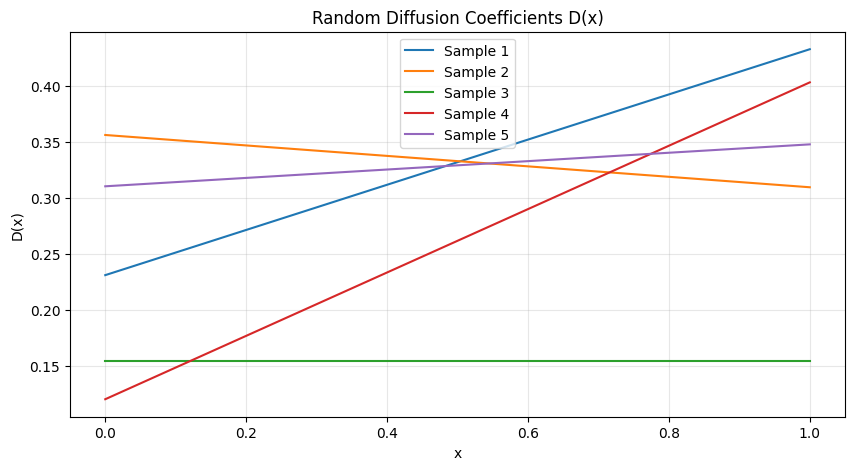

In [5]:
plt.figure(figsize=(10, 5))
for i in range(5): # Plot first 5 samples
    plt.plot(x_grid, D_data[i], label=f'Sample {i+1}')

plt.title("Random Diffusion Coefficients D(x)")
plt.xlabel("x")
plt.ylabel("D(x)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Using FTCS FDM with steps savers to solve this PDE 

\begin{equation*}
    \frac{\partial u}{\partial t} = \frac{\partial}{\partial x}\left[D \frac{\partial u}{\partial x}\right]
\end{equation*}

In [6]:
        
def solve_diffusion_fdm(D, x_grid, nt_save=100, T_max=1.0, u_init=None,bc='dirichlet') :
    
    Nx=100
    Nt = int(2*0.5*Nx**2)
    t_grid = np.linspace(0,T_max,Nt)

    dx = x_grid[1] - x_grid[0]
    dt = t_grid[1] - t_grid[0]

    nt_save_index = np.linspace(0,Nt-1,nt_save).astype(int)

    

    if u_init is not None :
        u_init = u_init
    else :
        u_init = np.abs(np.sin(np.pi*x_grid))

    u_sol = [u_init]

    
    D_interfaces = 0.5 * (D[1:] + D[:-1])  # Shape: (Nx-1,)

    
    for n in range(Nt-1):
        u_n = u_sol[n]
        u_nplus1 = np.zeros_like(u_n)
        
       
        delta_u_interfaces = u_n[1:] - u_n[:-1]      # Shape: (Nx-1,)
        
        
        fluxes = D_interfaces * delta_u_interfaces    # Shape: (Nx-1,)
        
        
        flux_divergence = fluxes[1:] - fluxes[:-1]  # Shape: (Nx-2,)
        

        u_nplus1[1:-1] = u_n[1:-1] + flux_divergence*(dt/dx**2)
        
        if bc == 'dirichlet' :
            u_nplus1[0] = 0.0
            u_nplus1[-1] = 0.0
        elif bc == 'neumann' :
            u_nplus1[0] = u_n[0] + (D[0] + D[1])/2 * (u_n[1] - u_n[0])*(dt/dx**2)
            u_nplus1[-1] = u_n[-1] - (D[-2] + D[-1])/2 * (u_n[-1] - u_n[-2])*(dt/dx**2)
            


        
        u_sol.append(u_nplus1)

    u_sol = np.array(u_sol)
    return u_sol[nt_save_index]
        
        

The following is non-vectorized way of doing the same thing as above (it takes way more time to solve with below code)

```python

def solve_diffusion_fdm(D, x_grid, nt_save=100, T_max=1.0, u_init=None) :

    Nx=100


    Nt = int(2*0.5*Nx**2)
    t_grid = np.linspace(0,T_max,Nt)

    dx = x_grid[1] - x_grid[0]
    dt = t_grid[1] - t_grid[0]

    nt_save_index = np.linspace(0,Nt-1,nt_save).astype(int)


    if u_init is not None :
        u_init = u_init
    else :
        u_init = np.abs(np.sin(np.pi*x_grid))

    u_sol = [u_init]

    for n in range(Nt-1) :
        u_n = u_sol[n]
        u_nplus1 = np.zeros_like(u_n)
        for j in range(1,Nx-1) :
            r_left = (D[j] + D[j+1])/2 *dt /(dx**2)
            r_right = (D[j-1] + D[j])/2 *dt /(dx**2)
            u_nplus1[j] = u_n[j] + r_left*(u_n[j+1] - u_n[j]) -  r_right*(u_n[j] - u_n[j-1])

    # Boundary conditions (Dirichlet Here)
        u_nplus1[0] = 0
        u_nplus1[-1] = 0

        u_sol.append(u_nplus1)
    
    u_sol = np.array(u_sol)

    return u_sol[nt_save_index]
        
        

```

In [ ]:

nt_steps = 150
T_max = 1.0

all_solutions = []

print("Solving PDEs...")
for i in range(len(D_data)):
    sol = solve_diffusion_fdm(D_data[i], x_grid,nt_save=nt_steps, T_max=T_max,bc='neumann')
    all_solutions.append(sol)
    
    if (i+1) % 50 == 0:
        print(f"Solved {i+1}/{len(D_data)}")

all_solutions = np.array(all_solutions)
print(f"Solutions Shape: {all_solutions.shape}") 


Solving PDEs...
Solved 50/1000
Solved 100/1000
Solved 150/1000
Solved 200/1000
Solved 250/1000
Solved 300/1000
Solved 350/1000
Solved 400/1000
Solved 450/1000
Solved 500/1000
Solved 550/1000
Solved 600/1000
Solved 650/1000
Solved 700/1000
Solved 750/1000
Solved 800/1000
Solved 850/1000
Solved 900/1000
Solved 950/1000
Solved 1000/1000
Solutions Shape: (1000, 150, 100)


In [38]:
print(all_solutions[0])

[[0.00000000e+00 3.17279335e-02 6.34239197e-02 ... 6.34239197e-02
  3.17279335e-02 1.22464680e-16]
 [1.26058156e-01 1.30650961e-01 1.39608693e-01 ... 1.79022910e-01
  1.72911435e-01 1.69840047e-01]
 [1.84000275e-01 1.87214019e-01 1.93530155e-01 ... 2.46255744e-01
  2.42176599e-01 2.40135481e-01]
 ...
 [6.28629384e-01 6.28631572e-01 6.28635908e-01 ... 6.31537006e-01
  6.31539005e-01 6.31540001e-01]
 [6.28662392e-01 6.28664534e-01 6.28668778e-01 ... 6.31509129e-01
  6.31511088e-01 6.31512063e-01]
 [6.28695178e-01 6.28697273e-01 6.28701426e-01 ... 6.31481425e-01
  6.31483343e-01 6.31484297e-01]]


Text(0, 0.5, 't')

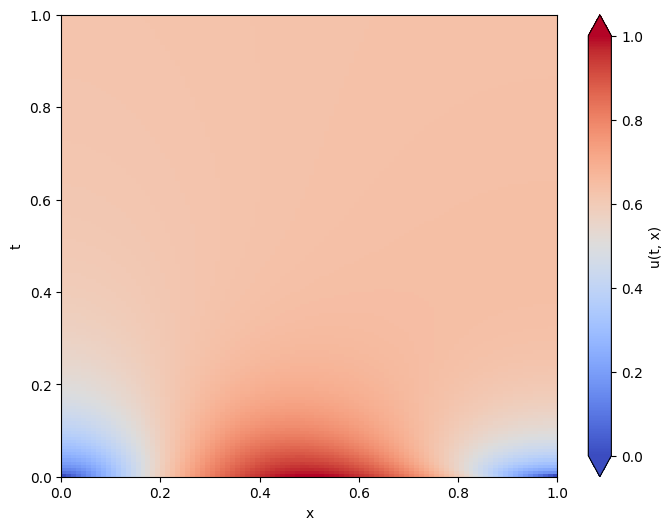

In [39]:
plt.figure(figsize=(8, 6))


u = all_solutions[3]

vmin, vmax = 0, 1

im = plt.imshow(u, vmin=vmin, vmax=vmax, 
                cmap='coolwarm', aspect='auto', origin='lower',
                extent=[0, 1, 0, 1])


plt.colorbar(im, label='u(t, x)', extend='both') 
plt.xlabel('x')
plt.ylabel('t')



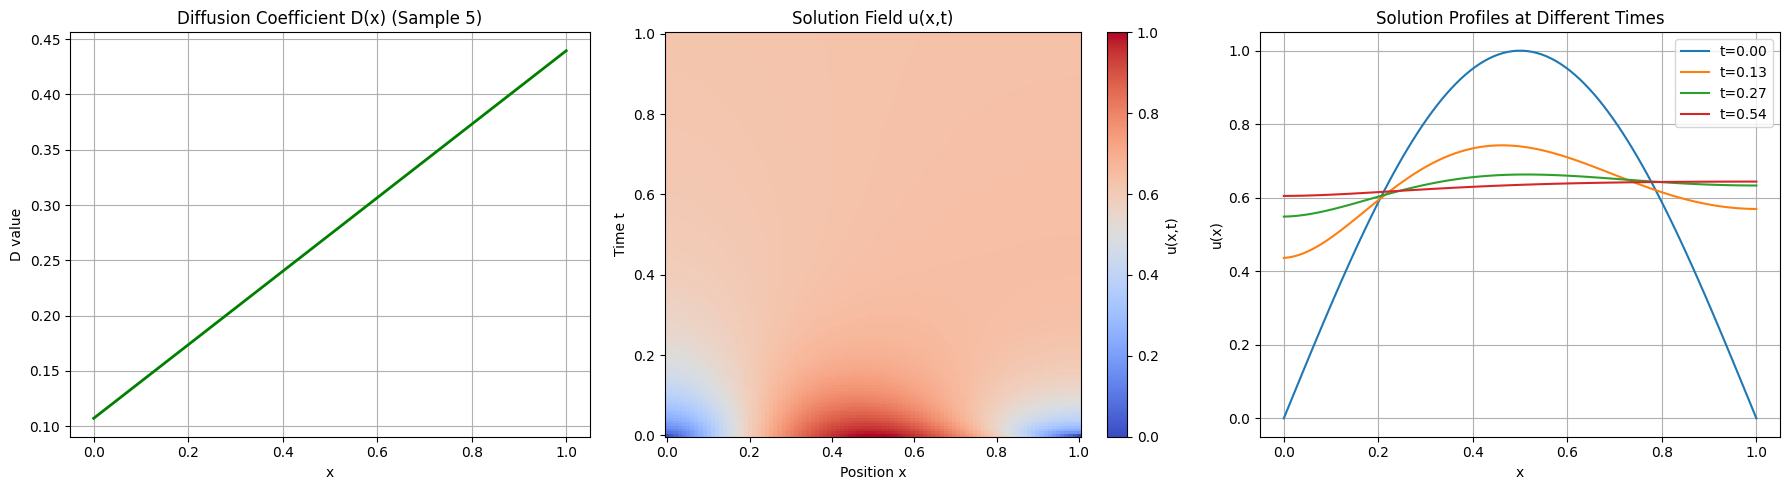

In [40]:

sample_idx = 5 #Random index for visualization #sample 76 almost has D = constant
u_field = all_solutions[sample_idx]
D_profile = D_data[sample_idx]


t_vals = np.linspace(0, 1.0, u_field.shape[0])
x_vals = x_grid
X, T = np.meshgrid(x_vals, t_vals)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))


axes[0].plot(x_vals, D_profile, color='green', linewidth=2)
axes[0].set_title(f"Diffusion Coefficient D(x) (Sample {sample_idx})")
axes[0].set_xlabel("x")
axes[0].set_ylabel("D value")
axes[0].grid(True)


c = axes[1].pcolormesh(X, T, u_field, shading='auto', cmap='coolwarm',vmin =0,vmax=1)
fig.colorbar(c, ax=axes[1], label='u(x,t)')
axes[1].set_title("Solution Field u(x,t)")
axes[1].set_xlabel("Position x")
axes[1].set_ylabel("Time t")



times_to_plot = [0, 20, 40, 80]
for tidx in times_to_plot:
    t_val = t_vals[tidx]
    axes[2].plot(x_vals, u_field[tidx, :], label=f't={t_val:.2f}')

axes[2].set_title("Solution Profiles at Different Times")
axes[2].set_xlabel("x")
axes[2].set_ylabel("u(x)")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


## ML Part

..

In [41]:
import torch


branch_inputs = torch.tensor(D_data, dtype=torch.float32)

print(f"Branch Inputs Shape: {branch_inputs.shape}")



Branch Inputs Shape: torch.Size([1000, 100])


In [42]:


t_grid, x_grid_mesh = np.meshgrid(t_vals, x_vals, indexing='ij') 



time_flat = t_grid.flatten()
space_flat = x_grid_mesh.flatten()

trunk_inputs = np.stack([space_flat, time_flat], axis=1)
trunk_inputs = torch.tensor(trunk_inputs, dtype=torch.float32)

print(f"Trunk Inputs Shape: {trunk_inputs.shape}")



Trunk Inputs Shape: torch.Size([15000, 2])


In [43]:

num_samples = all_solutions.shape[0]
num_points = trunk_inputs.shape[0]

targets = all_solutions.reshape(num_samples, num_points)
targets = torch.tensor(targets, dtype=torch.float32)

print(f"Targets Shape: {targets.shape}")



Targets Shape: torch.Size([1000, 15000])


In [44]:
from sklearn.model_selection import train_test_split


indices = np.arange(num_samples)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_branch = branch_inputs[train_idx]
train_targets = targets[train_idx]

test_branch = branch_inputs[test_idx]
test_targets = targets[test_idx]

print(f"Training Samples: {train_branch.shape[0]}")
print(f"Testing Samples: {test_branch.shape[0]}")


Training Samples: 800
Testing Samples: 200


Making DeepONet model

In [45]:
import torch.nn as nn
import torch.nn.functional as F

class DeepONet(nn.Module):
    def __init__(self, num_sensors, num_output_features=50):
        super(DeepONet, self).__init__()
        
        
        self.branch_net = nn.Sequential(
            nn.Linear(num_sensors, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_output_features),
        )
        
        
        self.trunk_net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, num_output_features),
        )
        
        
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, branch_in, trunk_in):
       
      
        B = self.branch_net(branch_in)
        
        
        T = self.trunk_net(trunk_in)
        
     
        output = torch.matmul(B, T.T)
        
        # Add bias
        output = output + self.bias
        
        return output


In [46]:

model = DeepONet(num_sensors=100, num_output_features=50)


dummy_branch = torch.randn(10, 100)  
dummy_trunk = torch.randn(500, 2)    


prediction = model(dummy_branch, dummy_trunk)

print(f"Output Shape: {prediction.shape}")


Output Shape: torch.Size([10, 500])


Training

In [47]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
learning_rate = 0.0016
epochs = 700 
batch_size = 100


deeponet = DeepONet(num_sensors=100, num_output_features=50).to(device)


optimizer = torch.optim.Adam(deeponet.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


Using device: cpu


In [48]:

from torch.utils.data import DataLoader, TensorDataset


train_dataset = TensorDataset(train_branch, train_targets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


trunk_inputs_gpu = trunk_inputs.to(device)


loss_history = []

print("Starting DeepONet training...")

for epoch in range(epochs):
    epoch_loss = 0.0
    
    for batch_branch, batch_targets in train_loader:
       
        batch_branch = batch_branch.to(device)
        batch_targets = batch_targets.to(device)
        
       
        optimizer.zero_grad()
        
        
        predictions = deeponet(batch_branch, trunk_inputs_gpu)
        
       
        loss = criterion(predictions, batch_targets)
        
        
        loss.backward()
        
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
   
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

print("Training Complete.")


Starting DeepONet training...
Epoch [10/700], Loss: 0.004976
Epoch [20/700], Loss: 0.004842
Epoch [30/700], Loss: 0.004587
Epoch [40/700], Loss: 0.003893
Epoch [50/700], Loss: 0.002757
Epoch [60/700], Loss: 0.002116
Epoch [70/700], Loss: 0.001266
Epoch [80/700], Loss: 0.001149
Epoch [90/700], Loss: 0.000766
Epoch [100/700], Loss: 0.000695
Epoch [110/700], Loss: 0.000494
Epoch [120/700], Loss: 0.000448
Epoch [130/700], Loss: 0.001208
Epoch [140/700], Loss: 0.002939
Epoch [150/700], Loss: 0.000320
Epoch [160/700], Loss: 0.000491
Epoch [170/700], Loss: 0.000331
Epoch [180/700], Loss: 0.000434
Epoch [190/700], Loss: 0.000239
Epoch [200/700], Loss: 0.000240
Epoch [210/700], Loss: 0.000347
Epoch [220/700], Loss: 0.000212
Epoch [230/700], Loss: 0.000240
Epoch [240/700], Loss: 0.000221
Epoch [250/700], Loss: 0.000194
Epoch [260/700], Loss: 0.000203
Epoch [270/700], Loss: 0.000217
Epoch [280/700], Loss: 0.000545
Epoch [290/700], Loss: 0.000170
Epoch [300/700], Loss: 0.000506
Epoch [310/700], Lo

Learning curve

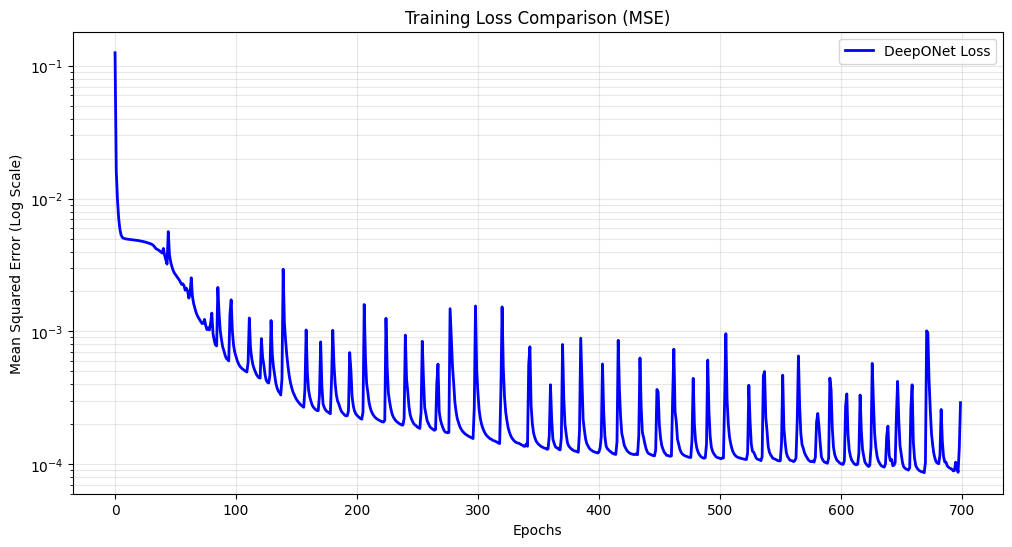

In [49]:
plt.figure(figsize=(12, 6))


plt.plot(loss_history, label='DeepONet Loss', linewidth=2, color='blue')



plt.yscale('log') 
plt.title("Training Loss Comparison (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (Log Scale)")
plt.legend()
plt.grid(True, which="both", alpha=0.3)

plt.show()


Evalution

In [50]:

deeponet.eval()


test_branch_gpu = test_branch.to(device)
test_targets_gpu = test_targets.to(device)
trunk_inputs_gpu = trunk_inputs.to(device)

with torch.no_grad():
    
    don_preds = deeponet(test_branch_gpu, trunk_inputs_gpu)
    
   
    don_mse = criterion(don_preds, test_targets_gpu).item()
    
    
    error_norms = torch.norm(don_preds - test_targets_gpu, p=2, dim=1)
    true_norms = torch.norm(test_targets_gpu, p=2, dim=1)
    don_rel_l2 = torch.mean(error_norms / true_norms).item()

print(f"DeepONet Test MSE: {don_mse:.6f}")
print(f"DeepONet Relative L2 Error: {don_rel_l2 * 100:.2f}%")


DeepONet Test MSE: 0.000265
DeepONet Relative L2 Error: 2.56%


Prediction Visualization

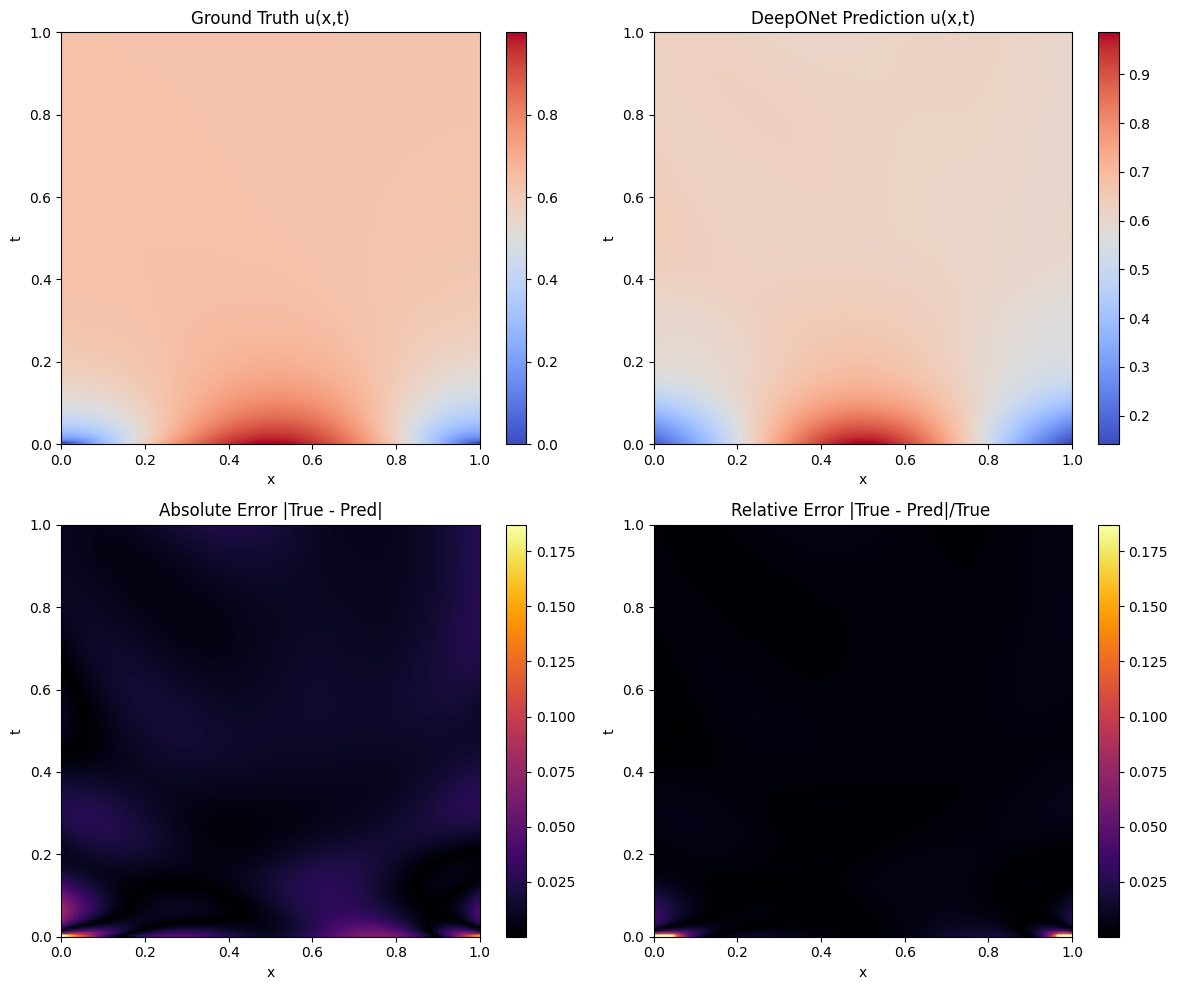

In [53]:

sample_idx = 70


D_input = test_branch[sample_idx].numpy()
true_sol_flat = test_targets[sample_idx].numpy()


d_tensor = torch.tensor(D_input, dtype=torch.float32).unsqueeze(0).to(device)
trunk_gpu = trunk_inputs.to(device)

with torch.no_grad():
    pred_don_flat = deeponet(d_tensor, trunk_gpu).cpu().numpy().flatten()


nt_steps=150
nx_plot = 100

U_true = true_sol_flat.reshape(nt_steps, nx_plot)
U_pred = pred_don_flat.reshape(nt_steps, nx_plot)
Error_absolute = np.abs(U_true - U_pred)
Error_relative = np.abs(U_true - U_pred)/np.where(U_true == 0,1e-6,U_true)


fig, axes = plt.subplots(2, 2, figsize=(12,10))


h1 = axes[0][0].imshow(U_true, aspect='auto', origin='lower', extent=[0,1,0,1], cmap='coolwarm')
axes[0][0].set_title("Ground Truth u(x,t)")
axes[0][0].set_xlabel("x")
axes[0][0].set_ylabel("t")
fig.colorbar(h1, ax=axes[0][0])


h2 = axes[0][1].imshow(U_pred, aspect='auto', origin='lower', extent=[0,1,0,1], cmap='coolwarm')
axes[0][1].set_title("DeepONet Prediction u(x,t)")
axes[0][1].set_xlabel("x")
axes[0][1].set_ylabel("t")
fig.colorbar(h2, ax=axes[0][1])


h3 = axes[1][0].imshow(Error_absolute, aspect='auto', origin='lower', extent=[0,1,0,1], cmap='inferno')
axes[1][0].set_title("Absolute Error |True - Pred|")
axes[1][0].set_xlabel("x")
axes[1][0].set_ylabel("t")
fig.colorbar(h3, ax=axes[1][0])

h4 = axes[1][1].imshow(Error_relative, aspect='auto', origin='lower', extent=[0,1,0,1], cmap='inferno',vmin=0,vmax=1)
axes[1][1].set_title("Relative Error |True - Pred|/True ")
axes[1][1].set_xlabel("x")
axes[1][1].set_ylabel("t")
fig.colorbar(h3, ax=axes[1][1])

plt.tight_layout()
plt.savefig("figure1.pdf")
plt.show()



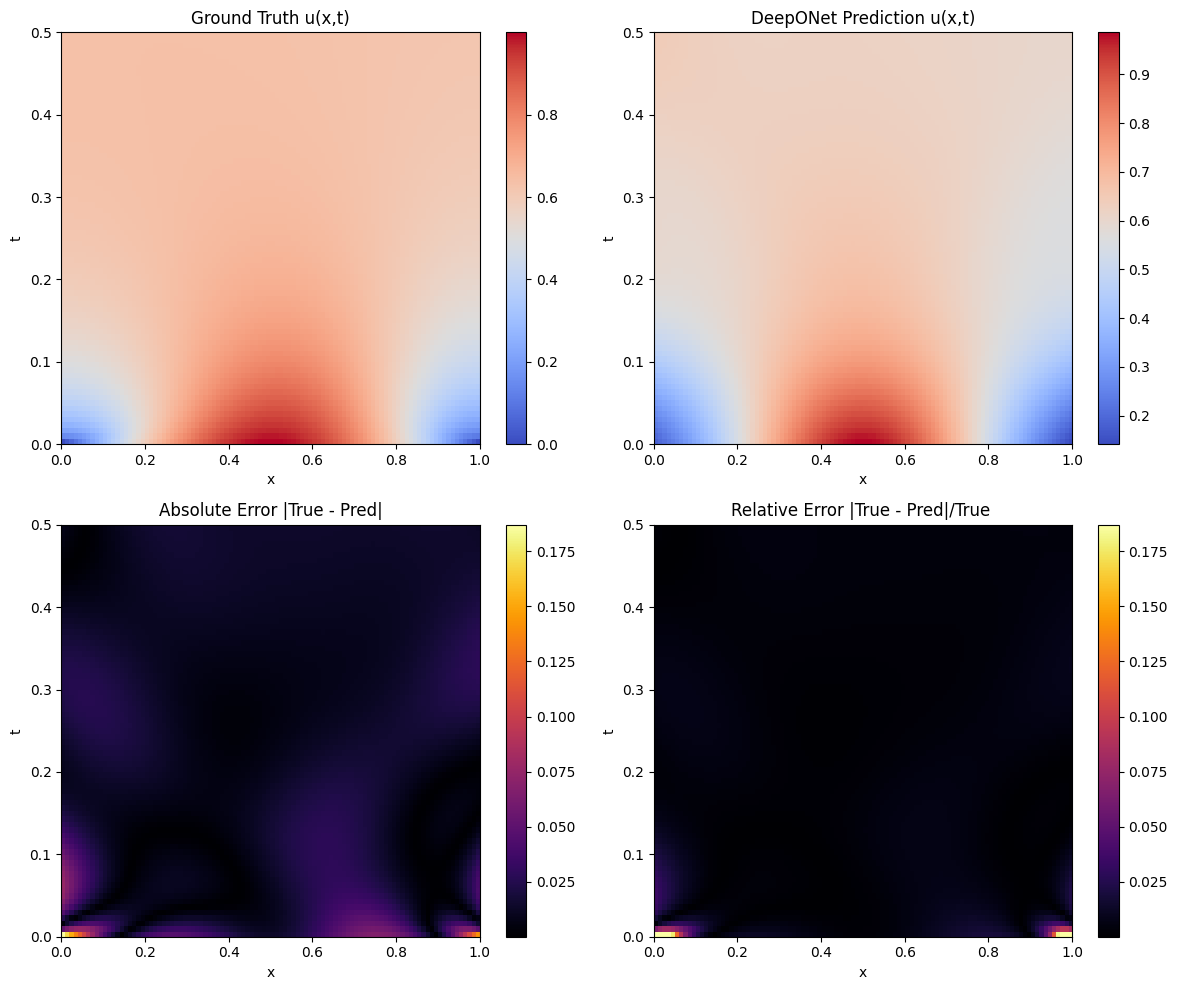

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))


tmax = 0.5
U_true_partial = U_true[:int(tmax*U_true.shape[0]),:]
U_pred_partial = U_pred[:int(tmax*U_true.shape[0]),:]
Error_partial_absolute = np.abs(U_pred_partial - U_true_partial)

Error_partial_relative = np.abs(U_pred_partial - U_true_partial)/np.where(U_true_partial==0,1e-6,U_true_partial)



h1 = axes[0][0].imshow(U_true_partial, aspect='auto', origin='lower', extent=[0,1,0,tmax], cmap='coolwarm')
axes[0][0].set_title("Ground Truth u(x,t)")
axes[0][0].set_xlabel("x")
axes[0][0].set_ylabel("t")
fig.colorbar(h1, ax=axes[0][0])


h2 = axes[0][1].imshow(U_pred_partial, aspect='auto', origin='lower', extent=[0,1,0,tmax], cmap='coolwarm')
axes[0][1].set_title("DeepONet Prediction u(x,t)")
axes[0][1].set_xlabel("x")
axes[0][1].set_ylabel("t")
fig.colorbar(h2, ax=axes[0][1])


h3 = axes[1][0].imshow(Error_partial_absolute, aspect='auto', origin='lower', extent=[0,1,0,tmax], cmap='inferno')
axes[1][0].set_title("Absolute Error |True - Pred|")
axes[1][0].set_xlabel("x")
axes[1][0].set_ylabel("t")
fig.colorbar(h3, ax=axes[1][0])

h4 = axes[1][1].imshow(Error_partial_relative, aspect='auto', origin='lower', extent=[0,1,0,tmax], cmap='inferno',vmin=0,vmax=1)
axes[1][1].set_title("Relative Error |True - Pred|/True ")
axes[1][1].set_xlabel("x")
axes[1][1].set_ylabel("t")
fig.colorbar(h3, ax=axes[1][1])

plt.tight_layout()
plt.savefig("figure1.pdf")
plt.show()

